### Install Libraries and Models 

In [ ]:
#Install needed packages and NLP models
!pip install -U pysolr
!pip install -U scispacy
!pip install -U jsonpath-ng
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_md-0.2.4.tar.gz
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_ner_craft_md-0.2.4.tar.gz
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_ner_jnlpba_md-0.2.4.tar.gz
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_ner_bc5cdr_md-0.2.4.tar.gz
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_ner_bionlp13cg_md-0.2.4.tar.gz

In [ ]:
!wget -O solr-8.5.0.zip "https://archive.apache.org/dist/lucene/solr/8.5.0/solr-8.5.0.zip";
!unzip solr-8.5.0.zip

In [ ]:
!ls

### Data Preprocessing

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
import os
import json
import glob
import re
import time
import pysolr
import csv
import time
import scipy
import spacy
import scispacy
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from os import path
from pandas import ExcelWriter
from pandas import ExcelFile
from jsonpath_ng.ext import parse
from collections import Counter
from collections import OrderedDict

### Preprocessing data

In [ ]:
def clean_text(text) :
    text = re.sub(r" ?\([^)]*\)", "", text)
    text = re.sub(r" ?\[[^)]*\]", "", text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"  ", " ", text)
    return text

In [ ]:
def preprocess_data() :
    start = time.time()

    meta_df = pd.read_csv('/kaggle/input/CORD-19-research-challenge/metadata.csv', sep=',', header=0)
    meta_columns = list(meta_df.columns)
    meta_df.fillna('', inplace=True)

    # Filter to pick only needed sections
    include_set = ['Abstract','Introduction', 'background', 'Discussion', 'Results', 'Results and Discussion', 'methods,results']
    section_df = pd.read_excel('/kaggle/input/covidsectionheads/covid_section_heads.xlsx', sheet_name='Sheet1')
    section_df.dropna(subset=['Section Heads'], inplace=True)
    section_df = section_df[section_df['Section Heads'].isin(include_set)]

    # Categories/Targets to pick from Section Heads column
    introduction_categories = ["Introduction"]
    discussion_categories = ["Discussion"]
    result_categories = ["Results", "Results and Discussion", 'methods,results']

    introduction_df = section_df[section_df['Section Heads'].isin(introduction_categories)]
    discussion_df = section_df[section_df['Section Heads'].isin(discussion_categories)]
    result_df = section_df[section_df['Section Heads'].isin(result_categories)]

    intro_list = introduction_df.iloc[:, 0].tolist()
    discussion_list = discussion_df.iloc[:, 0].tolist()
    result_list = result_df.iloc[:, 0].tolist()

    intro_list = list(map(lambda x: str(x).strip(), intro_list))
    discussion_list = list(map(lambda x: str(x).strip(), discussion_list))
    result_list = list(map(lambda x: str(x).strip(), result_list))

    path = '/kaggle/input/CORD-19-research-challenge/'
    paths = [p for p in glob.glob(path + "**/*.json", recursive=True)]
    files_size = len(paths)

    col_names = ['paper_id','title','source', 'abstract','introduction','discussion','result','body', 'has_covid']
    clean_df = pd.DataFrame(columns=col_names)

    covid_syns = ['COVID-19','COVID19','2019-nCoV','2019nCoV','Coronavirus','SARS-CoV-2','SARSCov2','novel Coronavirus']

    target_empty_count = 0

    abstract_expr = parse('$.abstract[*].text')

    for path in paths:
        with open(path) as f:
            intro_text_list = list()
            discussion_text_list = list()
            result_text_list = list()

            data = json.load(f)

            abstract_texts = [match.value for match in abstract_expr.find(data)]

            body_nodes = data['body_text']

            for entry in body_nodes :
                section_name = entry['section']
                section_name = section_name.strip().lower()
                entry_text = entry['text']

                if section_name.strip() in intro_list:
                    intro_text_list.append(entry_text)

                if section_name.strip() in discussion_list:
                    discussion_text_list.append(entry_text)

                if section_name.strip() in result_list:
                    result_text_list.append(entry_text)

            if len(intro_text_list) == 0 and len(discussion_text_list) == 0 and len(result_text_list) == 0 :
                target_empty_count = target_empty_count + 1


            id = data['paper_id']
            title = data['metadata']['title']

            pubtime_df = meta_df[meta_df.sha == id]['publish_time']
            pubtime_dict = pubtime_df.to_dict()
            pubtime = ''
            for pubtime_field_key in pubtime_dict.keys():
                pubtime = pubtime_dict.get(pubtime_field_key)        

            sha_df = meta_df[meta_df.sha == id]['source_x']
            meta_dict = sha_df.to_dict()
            source = ''
            for meta_field_key in meta_dict.keys():
                source = meta_dict.get(meta_field_key)

            if not source:
                title_df = meta_df[meta_df.title == title]['source_x']
                meta_dict = title_df.to_dict()
                for meta_field_key in meta_dict.keys():
                    source = meta_dict.get(meta_field_key)

            abstract = clean_text(" ".join(abstract_texts))
            introduction = clean_text(" ".join(intro_text_list))
            discussion = clean_text(" ".join(discussion_text_list))
            result = clean_text(" ".join(result_text_list))
            body = " ".join([introduction, discussion, result])

            has_covid = 'false'

            res = [ele for ele in covid_syns if (ele.lower() in body.lower())]
            if(len(res)  > 0):
                has_covid = 'true'

            if len(body.strip()) > 0 or len(abstract) > 0:
                new_row = {'paper_id': id, 'title': title.strip(), 'source': source,'abstract': abstract.strip(),
                           'introduction': introduction.strip(),'discussion': discussion.strip(),
                           'result': result.strip(), 'body': body.strip(), 'publish_time': pubtime,'has_covid': has_covid}
                clean_df = clean_df.append(new_row, ignore_index=True)

    # Drop duoplicate papers
    clean_df.drop_duplicates(subset=['title','abstract'], keep='first', inplace=False)
    clean_df.to_csv('/kaggle/working/CORD-19.csv', index=True)

    print('Final DataFrame Shape - ', clean_df.shape)
    print("Papers that dont have Intro, Discussion or Result  - ", target_empty_count)
    print('Total Papers processed - ', files_size)

    print('Time Elaspsed - ', time.time() - start)
    

### Configure Search Engine

In [ ]:
!solr-8.5.0/bin/solr start -force

In [ ]:
!solr-8.5.0/bin/solr create -c covid19 -s 1 -rf 1 -force

In [ ]:
# Using _default configset with data driven schema functionality. NOT RECOMMENDED for production use.
!solr-8.5.0/bin/solr config -c covid19 -p 8983 -action set-user-property -property update.autoCreateFields -value false

In [ ]:
#Set Up Synonyms

!echo 'COVID-19,covid19,2019-nCoV,2019nCoV,Coronavirus,SARS-CoV-2,SARSCov2,novel Coronavirus' >> solr-8.5.0/server/solr/covid19/conf/synonyms.txt;
!echo 'heart,cardiac,tachycardia,myocardial' >> solr-8.5.0/server/solr/covid19/conf/synonyms.txt;
!echo 'pulmonary,respiratory' >> solr-8.5.0/server/solr/covid19/conf/synonyms.txt;

In [ ]:
!cat solr-8.5.0/server/solr/covid19/conf/synonyms.txt

In [ ]:
#Reload the covid19 core/collection because we added new synonyms. Need reload as it will affect index
#Whenever new synonyms are added we need to reindex as synonyms are applied both on index and query analyzers
!curl 'http://localhost:8983/solr/admin/cores?action=RELOAD&core=covid19'

In [ ]:
#Add custom field Type that wont tokenize phrases for fields like source etc
!curl -X POST -H 'Content-type:application/json' --data-binary '{"add-field-type" : {"name":"keywordText","class":"solr.TextField", "positionIncrementGap":"100", "indexAnalyzer" : {"tokenizer":{"class":"solr.KeywordTokenizerFactory" }, "filters":[{"class":"solr.TrimFilterFactory"},{"class":"solr.StopFilterFactory", "ignoreCase":true, "words":"lang/stopwords_en.txt"},{"class":"solr.ManagedSynonymGraphFilterFactory", "managed":"english" },{"class":"solr.RemoveDuplicatesTokenFilterFactory"},{"class":"solr.FlattenGraphFilterFactory"}]},"queryAnalyzer" : {"tokenizer":{"class":"solr.KeywordTokenizerFactory" },"filters":[{"class":"solr.TrimFilterFactory"},{"class":"solr.StopFilterFactory", "ignoreCase":true, "words":"lang/stopwords_en.txt"},{"class":"solr.ManagedSynonymGraphFilterFactory", "managed":"english" },{"class":"solr.RemoveDuplicatesTokenFilterFactory"}]}}}' http://localhost:8983/solr/covid19/schema

In [ ]:
#Create SOLR field definitions
!curl -X POST -H 'Content-type:application/json' --data-binary '{"add-field": {"name":"title", "type":"text_en_splitting_tight", "multiValued":false, "stored":true, "indexed":true}}' http://localhost:8983/solr/covid19/schema;
!curl -X POST -H 'Content-type:application/json' --data-binary '{"add-field": {"name":"abstract", "type":"text_en_splitting_tight", "multiValued":false, "stored":true, "indexed":true}}' http://localhost:8983/solr/covid19/schema;
!curl -X POST -H 'Content-type:application/json' --data-binary '{"add-field": {"name":"source", "type":"keywordText", "multiValued":false, "stored":true, "indexed":true}}' http://localhost:8983/solr/covid19/schema;
!curl -X POST -H 'Content-type:application/json' --data-binary '{"add-field": {"name":"introduction", "type":"text_en_splitting_tight", "multiValued":false, "stored":true, "indexed":true}}' http://localhost:8983/solr/covid19/schema;
!curl -X POST -H 'Content-type:application/json' --data-binary '{"add-field": {"name":"discussion", "type":"text_en_splitting_tight", "multiValued":false, "stored":true, "indexed":true}}' http://localhost:8983/solr/covid19/schema;
!curl -X POST -H 'Content-type:application/json' --data-binary '{"add-field": {"name":"result", "type":"text_en_splitting_tight", "multiValued":false, "stored":true, "indexed":true}}' http://localhost:8983/solr/covid19/schema;
!curl -X POST -H 'Content-type:application/json' --data-binary '{"add-field": {"name":"body", "type":"text_en_splitting_tight", "multiValued":false, "stored":true, "indexed":true}}' http://localhost:8983/solr/covid19/schema;
!curl -X POST -H 'Content-type:application/json' --data-binary '{"add-field": {"name":"publish_time", "type":"pdate", "multiValued":false, "stored":true, "indexed":true}}' http://localhost:8983/solr/covid19/schema;
!curl -X POST -H 'Content-type:application/json' --data-binary '{"add-field": {"name":"has_covid", "type":"boolean", "multiValued":false, "stored":true, "indexed":true}}' http://localhost:8983/solr/covid19/schema;

### Create Search Index

In [ ]:
solr = pysolr.Solr('http://localhost:8983/solr/covid19/', timeout=10)

In [ ]:
#Load preprocessed CSV data
csv_path = '/kaggle/input/working/CORD-19.csv'

if not path.exists(csv_path):
    preprocess_data()
    
df = pd.read_csv(csv_path, sep=',', header=0)
df.fillna('', inplace=True)
#df = df[1:]
print('DF candidate_list size - ', df.shape)

df.head(2)

In [ ]:
# Index each pandas row as a document into SOLR search engine

covid_syns = ('SARSCoV2','SARS-CoV-2', '2019-nCoV','2019nCoV','COVID-19', 'COVID19','coronavirus', 'corona virus' 'novel coronavirus')

list_for_solr=[]
counter = 0
for index, row in df.iterrows():
    id = row['paper_id']
    title = row["title"]
    source = row["source"]    
    abstract = row["abstract"]
    introduction = row["introduction"]
    discussion = row["discussion"]
    result = row["result"]  
    body = row["body"]  # Cocatenated text of all text fields abstract, introduction, discussion, conclusion
    
    if((title and title.isspace()) and (abstract and abstract.isspace()) and (body and body.isspace())):
        continue
        
    has_covid = 'false'
    if any(words in body for words in covid_syns):
        has_covid = 'true'
    
    solr_content = {}
    solr_content['id'] = id
    solr_content['title'] = title
    solr_content['source'] = source
    solr_content['abstract'] = abstract
    solr_content['introduction'] = introduction
    solr_content['discussion'] = discussion
    solr_content['result'] = result    
    solr_content['body'] = body
    solr_content['has_covid'] = has_covid  
        
    list_for_solr.append(solr_content)
    
    if index % 100 == 0:
        solr.add(list_for_solr)
        list_for_solr = []
        counter = counter + 100
        print('Counter ', counter)
        
#Commit is very costly use it sparingly        
solr.commit()
print('Indexing Finished !')

In [ ]:
def extract_entities(models, text) :
    entities = {}
    
    for nlp in models :
        doc = nlp(text)
        for ent in doc.ents:
            entity = ent.text
            if ent.label_ in entities :
                if entities[ent.label_].count(ent.text) == 0:
                    entities[ent.label_].append(ent.text)
            else :
                entities[ent.label_] = [ent.text]

    return entities

In [ ]:
def initilize_nlp_models(model_names):
    models = {}
    for name in model_names:
        models['name'] = spacy.load(name)
    
    print('Models Loaded')
    return models

In [ ]:
def search_task_answers(query):
    # Search for data
    
    print('query - ', query)
    
    search_results = solr.search(query, **{
    'fq':'has_covid:true',
    'qf':'title^50.0 abstract^40.0 introduction^30.0 discussion^20.0 result^50.0 body^10.0',
    'pf':'title^60.0 abstract^50.0 introduction^40.0 discussion^30.0 result^60.0 body^20.0',
    'hl': 'true',
    'hl.bs.type': 'SENTENCE',
    'hl.method' : 'unified',
    'hl.snippets' : 5,
    'hl.usePhraseHighlighter': 'true',
    'hl.highlightMultiTerm' : 'true',
    'hl.tag.pre':'',
    'hl.tag.post':'',
    'df':'body',
    'hl.fl':'introduction,discussion,result'
    })

    numDocsFound = search_results.hits
    print('Total Search Hits - ', numDocsFound)
    print("Got Top {0} result(s) of total {1}.".format(len(search_results), numDocsFound))
    
    answers_list = list()
    
    for search_result in search_results:
        doc_hl_dict = {}        
#         print('ID : ', search_result['id'], '\nTITLE : ', search_result['title'])
        doc_highlights = search_results.highlighting[search_result['id']]
        
        doc_hl_dict['id'] = search_result['id']
        doc_hl_dict['title'] = search_result['title']        

        for doc_hl_field in doc_highlights:
            hl_snippets = doc_highlights[doc_hl_field]
        
            if len(hl_snippets) > 0 :
                answer_snippet = ''
                #print('\t', doc_hl_field)
                for index, snippet in enumerate(hl_snippets, start=1):
                    answer_snippet = answer_snippet.strip() + " " + snippet.strip()
                
                #print('\t\t', answer_snippet, '\n')                
                doc_hl_dict[doc_hl_field] = answer_snippet.strip()
                    
        if len(doc_hl_dict) > 0:
            answers_list.append(doc_hl_dict)
        
    answers = {"num_docs": numDocsFound, 'answers':answers_list} 
    return answers

In [ ]:
def populate_labels(task_answers) :
    field_list = ['introduction','discussion', 'conclusion']

    for doc_answer_dict in task_answers:
        all_entities = set()
        intro_entities = set()
        discussion_entities = set()
        conclusion_entities = set() 

        print('Title - ', doc_answer_dict['title'], '\n')

        for field_name, answer_text in doc_answer_dict.items():
            if field_name in field_list:
                ent_dict = extract_entities(chosen_models, answer_text)
                ent_list = ent_dict['ENTITY']

                all_entities.update(ent_list)
                if field_name == 'introduction' :
                    intro_entities.update(ent_list)
                elif field_name == 'discussion' :
                    discussion_entities.update(ent_list)
                else :
                    conclusion_entities.update(ent_list)

        # Now set up labels for entities
        prior_newdata_entities = set()
        prior_strong_entities = set()
        prior_entities = set()
        speculative_entities = set()
        unknown_entities = set()    
        novel_entities = set()

        for a_ent in all_entities :
            if a_ent in intro_entities and a_ent in conclusion_entities and a_ent in discussion_entities : 
                prior_newdata_entities.add(a_ent)
            elif a_ent in intro_entities and a_ent not in conclusion_entities and a_ent in discussion_entities :
                prior_strong_entities.add(a_ent)
            elif a_ent in intro_entities and a_ent not in conclusion_entities and a_ent not in discussion_entities :
                prior_entities.add(a_ent)
            elif a_ent not in intro_entities and a_ent in conclusion_entities and a_ent not in discussion_entities : 
                unknown_entities.add(a_ent)
            elif a_ent not in intro_entities and a_ent in conclusion_entities and a_ent in discussion_entities :
                novel_entities.add(a_ent)
            else :
                pass
            
        if(len(prior_newdata_entities) > 0) :
            doc_answer_dict['prior-newdata'] = list(prior_newdata_entities)

        if(len(prior_strong_entities) > 0) :
            doc_answer_dict['prior-strong'] = list(prior_strong_entities)

        if(len(prior_entities) > 0) :
            doc_answer_dict['prior'] = list(prior_entities)

        if(len(speculative_entities) > 0) :
            doc_answer_dict['speculative'] = list(speculative_entities)

        if(len(unknown_entities) > 0) :
            doc_answer_dict['unknown'] = list(unknown_entities) 

        if(len(novel_entities) > 0) :
            doc_answer_dict['novel'] = list(novel_entities)         


        print(doc_answer_dict)
        print('----')
    return task_answers

### What do we know about COVID-19 risk factors?

Task Details

What do we know about COVID-19 risk factors? What have we learned from epidemiological studies?
Specifically, we want to know what the literature reports about:

* Data on potential risks factors
    1. Smoking, pre-existing pulmonary disease
    2. Co-infections (determine whether co-existing respiratory/viral infections make the virus more transmissible or virulent) and other co-morbidities
    3. Neonates and pregnant women
    4. Socio-economic and behavioral factors to understand the economic impact of the virus and whether there were differences.
* Transmission dynamics of the virus, including the basic reproductive number, incubation period, serial interval, modes of transmission and environmental factors
* Severity of disease, including risk of fatality among symptomatic hospitalized patients, and high-risk patient groups
* Susceptibility of populations
* Public health mitigation measures that could be effective for control


In [ ]:
tasks = ['Smoking and pre-existing pulmonary disease', 
         'Co-infections, co-morbidities and respiratory infections',
         'Neonates and pregnant women',
         'Socio-economic and behavioral factors to understand the economic impact of the virus and whether there were differences.',
         'Transmission dynamics of the virus, including the basic reproductive number, incubation period, serial interval, modes of transmission and environmental factors',
         'Severity of disease, including risk of fatality among symptomatic hospitalized patients, and high-risk patient groups'
         'Susceptibility of populations',
         'Public health mitigation measures that could be effective for control'
        ]

queries = ['("Smoking COVID-19"~10 OR "pulmonary disease"~10)', 
           '("Co-infections COVID-19"~10 OR "co-morbidities COVID-19"~10 OR "respiratory infections COVID-19"~10)',
           '("Neonates COVID-19"~10 OR "pregnant women COVID-19"~10)',
           'Socio-economic, behavioral factors and economic impact',
           'Transmission dynamics, basic reproductive number, incubation period, serial interval, modes of transmission and environmental factors',
           'Severity of disease, risk of fatality among symptomatic hospitalized patients and high-risk patient groups',
           'Susceptibility of populations',
           'Public health mitigation measures that are effective for control'
        ]

In [ ]:
#Load NLP Models only once
model_names = ['en_ner_craft_md','en_ner_jnlpba_md', 'en_ner_bc5cdr_md','en_ner_bionlp13cg_md']
models_dict = initilize_nlp_models(model_names)

In [ ]:
# Map entities existence in intro-conclusion-discussion respectively to label values
label_def = {'111':'prior-newdata','101':'prior-strong','100':'prior','001':'speculative','010':'unknown', '011':'novel'}
generic_model = spacy.load('en_core_sci_md')
chosen_models = list()
chosen_models.append(generic_model)

In [ ]:

for query in queries: 
    search_results = search_task_answers(queries[1])
    task_answers = search_results.get('answers')
    tak_answers = populate_labels(task_answers)
    print('###########################################################')


In [ ]:
task_answers

In [182]:
tak_answers

[{'id': '875b7c463f00772fa0dc18ada678bc1ff16a4274',
  'title': 'performed data analysis',
  'introduction': 'Since November 2019, the rapid outbreak of coronavirus disease 2019 , which arose from severe acute respiratory syndrome coronavirus 2 infection, has recently become a public health emergency of international concern .',
  'discussion': 'Our study is the first nationwide investigation that systematically evaluates the impact of comorbidities on the clinical characteristics and prognosis in patients with COVID-19 in China. Circulatory and endocrine comorbidities were common among patients with COVID-19. Comorbidities are present in around one fourth of patients with COVID-19 in China, and predispose to poorer clinical outcomes. A thorough assessment of comorbidities may help establish risk stratification of patients with COVID-19 upon hospital admission.',
  'prior': ['rapid',
   'acute respiratory syndrome coronavirus 2 infection',
   'coronavirus disease',
   'outbreak',
   'in

#### We will extract all the titles from the output and then assign them cosine scores. 
#### These title would then become our nodes and the cosine scores would define the distance between them

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

import warnings
warnings.filterwarnings('ignore')

def cosine_score(x):
    d = []
    for i in range(len(x)-1):
        for j in range(i+1,len(x)):
            doc1= nlp(x[i])
            doc2= nlp(x[j])
            d.append({

                'Title1': x[i],
                'Title2': x[j],
                'Score': doc1.similarity(doc2)
            }
        )
        
    return d

##### Extract the title list

In [191]:
title_list = []
for title in range(len(tak_answers)):
    title_list.append(tak_answers[title]['title'])

title_dict_temp = cosine_score(title_list)

title_df = pd.DataFrame(title_dict_temp)

title_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
Title1    45 non-null object
Title2    45 non-null object
Score     45 non-null float64
dtypes: float64(1), object(2)
memory usage: 1.2+ KB


##### Extract the word list along with their mappings to the titles and associated distance

In [151]:
word_df = pd.DataFrame(tak_answers)

word_df.drop(['introduction','discussion','result'],axis=1,inplace=True)

word_df.head(1)

,id,title,prior,prior-strong
0,875b7c463f00772fa0dc18ada678bc1ff16a4274,performed data analysis,"[rapid, acute respiratory syndrome coronavirus...",NaN


In [ ]:
word_df_prior = word_df[['id','title','prior']]
word_df_prior = word_df_prior.explode('prior')
word_df_prior.dropna(subset = ["prior"], inplace=True)
word_df_prior['Weight'] = 10


word_df_prior_strong = word_df[['id','title','prior-strong']]
word_df_prior_strong = word_df_prior_strong.explode('prior-strong')
word_df_prior_strong.dropna(subset = ["prior-strong"], inplace=True)
word_df_prior_strong['Weight'] = 5


# word_df_prior_newdata = word_df[['id','title','prior_newdata']]
# word_df_prior_newdata = word_df_prior_newdata.explode('prior_newdata')
# word_df_prior_newdata.dropna(subset = ["prior_newdata"], inplace=True)
# word_df_prior_newdata['Weight'] = 2


# word_df_speculative = word_df[['id','title','speculative']]
# word_df_speculative = word_df_speculative.explode('speculative')
# word_df_speculative.dropna(subset = ["speculative"], inplace=True)
# word_df_speculative['Weight'] = 15


# word_df_unknown = word_df[['id','title','unknown']]
# word_df_unknown = word_df_unknown.explode('unknown')
# word_df_unknown.dropna(subset = ["unknown"], inplace=True)
# word_df_unknown['Weight'] = 30



# word_df_novel = word_df[['id','title','novel']]
# word_df_novel = word_df_novel.explode('novel')
# word_df_novel.dropna(subset = ["novel"], inplace=True)
# word_df_novel['Weight'] = 25


#### Collating all the words and titles together and associating different 'groups' to them so as to color code them

In [192]:
# Take all the titles and categorize them into one group
title_df_1 = title_df[['Title1']]
title_df_1.drop_duplicates(inplace=True,keep='first')
title_df_1['Color'] = 'group1'
title_df_1.columns = ['Words','Color']

# Combine all the words and categorize them into one group

word_df_prior_1 = word_df_prior[['prior']]
word_df_prior_1.drop_duplicates(inplace=True)
word_df_prior_1['Color'] = 'group2'
word_df_prior_1.columns = ['Words','Color']


word_df_prior_strong_1 = word_df_prior_strong[['prior-strong']]
word_df_prior_strong_1.drop_duplicates(inplace=True)
word_df_prior_strong_1['Color'] = 'group2'
word_df_prior_strong_1.columns = ['Words','Color']


# Combining all the dataframe together in one place

frames = [title_df_1,word_df_prior_1,word_df_prior_strong_1]

merged_df = pd.concat(frames)

In [155]:
merged_df.drop_duplicates(subset='Words',keep='first',inplace=True)

In [156]:
merged_df.set_index('Words',inplace=True)

#### Creating the graph and adding nodes and edges

In [153]:
i = nx.Graph()

for row in title_df.iterrows():
    i.add_edge(row[1]['Title1'], row[1]['Title1'], weight=row[1]['Score'])
    
for row in word_df_prior.iterrows():
    i.add_edge(row[1]['title'], row[1]['prior'], weight=row[1]['Weight'])
    
for row in word_df_prior_strong.iterrows():
    i.add_edge(row[1]['title'], row[1]['prior-strong'], weight=row[1]['Weight'])
    

In [169]:
merged_df = merged_df.reindex(i.nodes())

merged_df['Color']=pd.Categorical(merged_df['Color'])

merged_df['Color'].cat.codes

Words
performed data analysis                                                                                                                                                                                     0
Title Systematic review and meta-analysis of predictive symptoms and comorbidities for severe COVID-19 infection                                                                                            0
European Journal of Case Reports in Internal Medicine Severe Immune Thrombocytopenia Complicated by Intracerebral Haemorrhage Associated with Coronavirus Infection: A Case Report and Literature Review    0
Sequential, within-season infection with influenza A (H3N2) in a usually healthy vaccinated child                                                                                                           0
Epidemiology of seasonal coronaviruses: Establishing the context for COVID-19 emergence                                                                                   

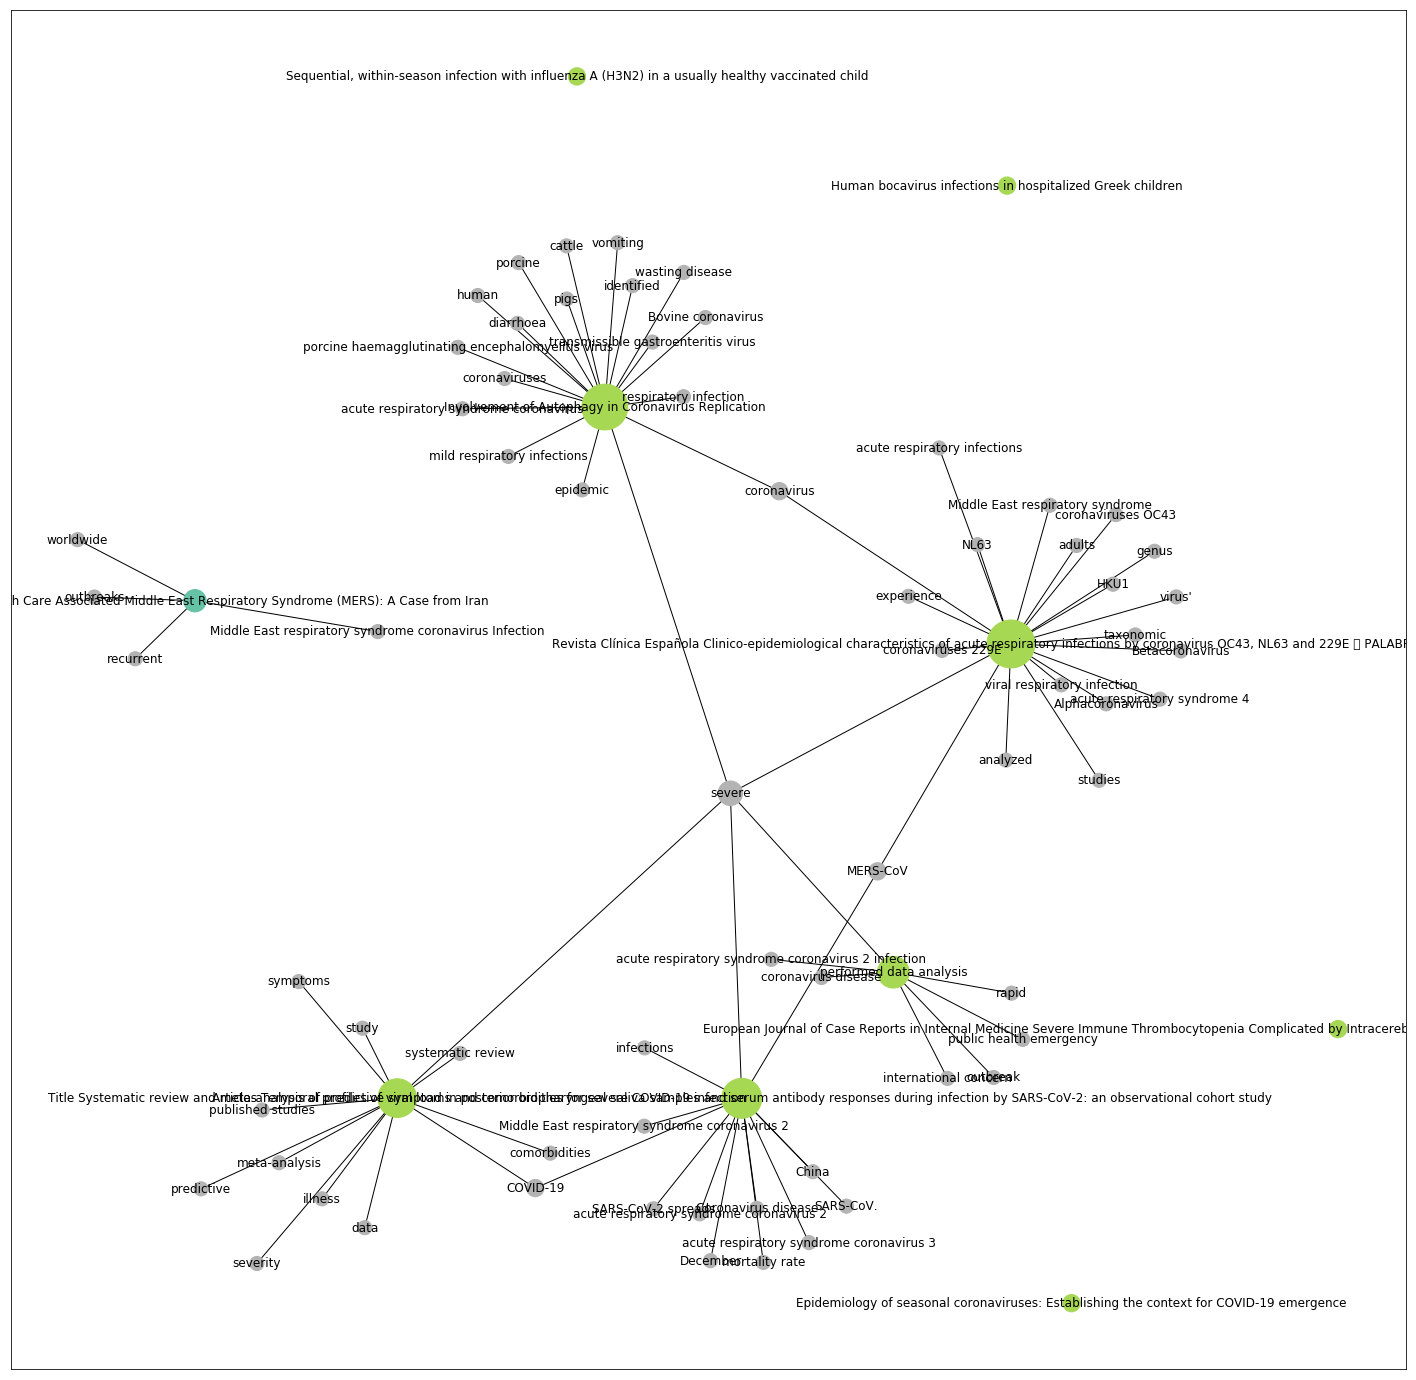

In [179]:
plt.figure(figsize=(22, 22))
degrees = nx.degree(i)
pos_node = nx.spring_layout(i,k=0.5)
nx.draw_networkx(i,pos=pos_node,node_color=merged_df['Color'].cat.codes, cmap=plt.cm.Set2,node_size=[(degrees[v] + 1) * 100 for v in i.nodes()])